In [53]:
import os, sys
#pathname = os.path.dirname(sys.argv[0])
#full_pathname = os.path.abspath(pathname)
#split_pathname = full_pathname.split(sep="mvesc")
#base_pathname = os.path.join(split_pathname[0], "mvesc")
#parentdir = os.path.join(base_pathname, "ETL")
#sys.path.insert(0,parentdir)
parentdir = os.path.abspath('/home/xcheng/mvesc/ETL')
sys.path.insert(0,parentdir)
from mvesc_utility_functions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Image

%load_ext autotime
%matplotlib inline

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 6.41 ms


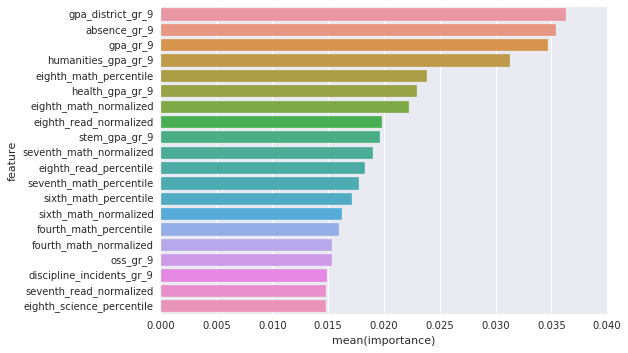

time: 532 ms


In [94]:
import seaborn as sns
sns.barplot(y=df.index, x=df['importance'])

In [152]:
def barplot_feature_importance(table, schema='feature_scores', topN=10, save=True, savedir='./', figname=None,
                            name_column='feature', value_column='importance', 
                            xlabel='', ylabel='', title='', fontsize=16, figsize=(12, 8),
                            style='ggplot', kind='barh', dpi=500):
    """
    Bar Plot of any table in mvesc postgres
    Designed for feature importance: only need to specificy table name
    Other tables: specify table, schema, name_column, value_column
    Example:
    1. RF/ET feature importance table: barplot_feature_importance('table')
    2. Other tables: barplot_feature_importance('table', schema='schema', name_column='label', value_column='')
    
    :param str table: table name in postgres
    :param str schema: schema name
    :param int topN: number of top features to plot
    :param bool save: whether to save the fig
    :param str savedir: directory to save the fig
    :param str figname: figure name
    :param str name_column: column name of the label
    :param str value_column: column name of the values
    :param str xlabel, ylabel, title:
    :param int fontsize: fontsize for labels and titles
    :param tuple int figsize: figure size
    :param str style: plot style, 'ggplot', 'fivethirtyeight', etc
    :param str kind: bar plot kind, `bar`, `barh`
    :param int dpi: resolution, the larger the better
    :return str fn: figure name; if save==False, return None  
    """
    plt.style.use(style)
    with postgres_pgconnection_generator() as conn:
        feature_importances = read_table_to_df(conn, table, schema=schema)

    df = feature_importances[[value_column]]
    df.index = feature_importances[name_column]
    df = df.sort_values(by=[value_column], ascending=False)
    df = df.iloc[:topN, :]
    ax = df.iloc[::-1,:].plot(kind=kind, title=title, figsize=figsize, fontsize=fontsize, legend=False)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.tight_layout()
    if save==True:
        if figname==None:
            fn = os.path.join(savedir, 'feature_importance_'+table+'.png')
        else:
            fn = str(figname)
        plt.savefig(fn, dpi=dpi)
    return(fn)

time: 16.9 ms


                             importance
feature                                
sixth_math_percentile          0.033087
eighth_math_normalized         0.032983
sixth_math_normalized          0.032733
eighth_math_percentile         0.030768
fifth_socstudies_normalized    0.025343
eighth_science_normalized      0.022331
eighth_science_percentile      0.022070
absence_gr_5                   0.021769
sixth_read_normalized          0.021488
seventh_read_percentile        0.021275
                             importance
feature                                
eighth_math_percentile         0.021371
eighth_math_normalized         0.021267
sixth_math_percentile          0.020963
sixth_math_normalized          0.020777
eighth_read_normalized         0.018775
gpa_district_gr_6              0.017972
absence_gr_6                   0.017844
fifth_socstudies_normalized    0.017508
eighth_science_normalized      0.017181
seventh_read_normalized        0.017095
                           importance
fe

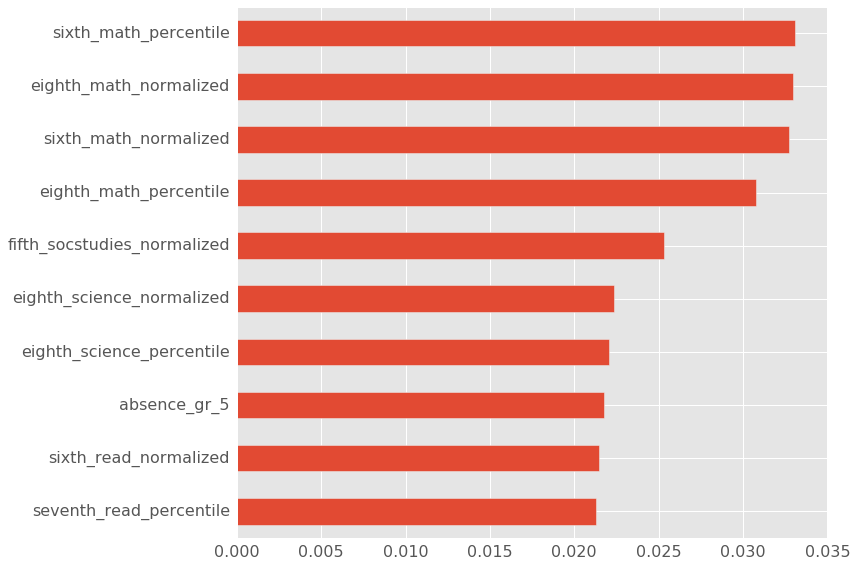

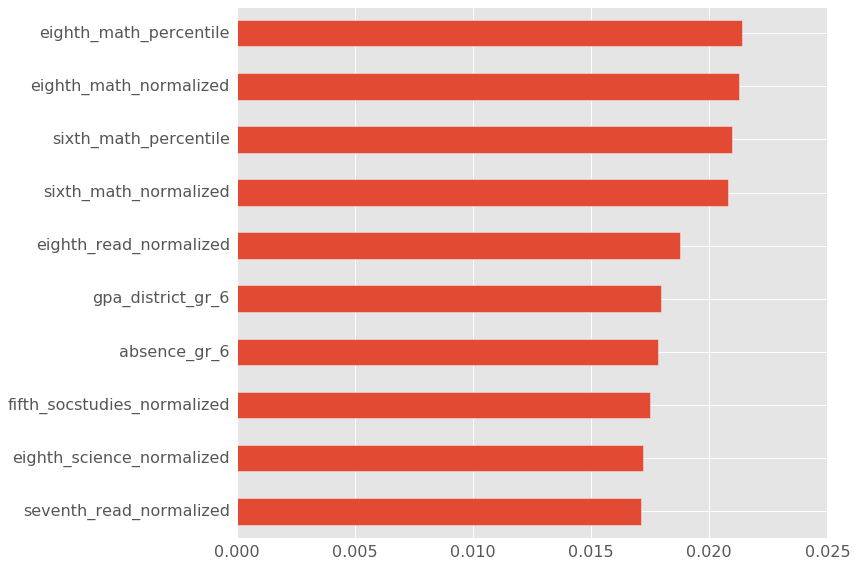

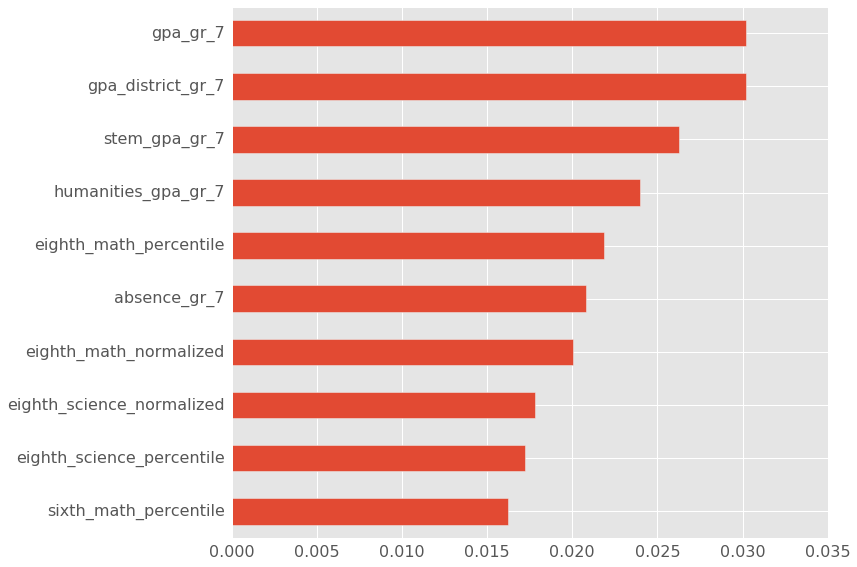

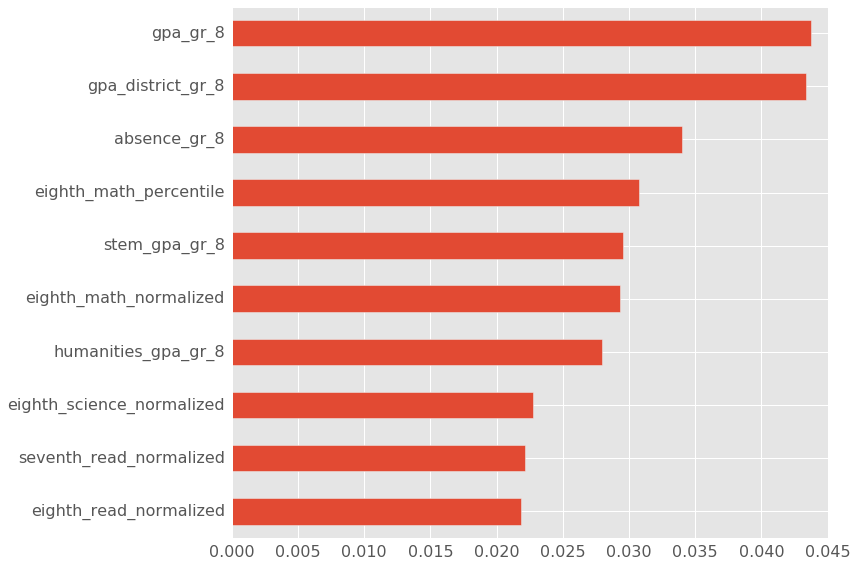

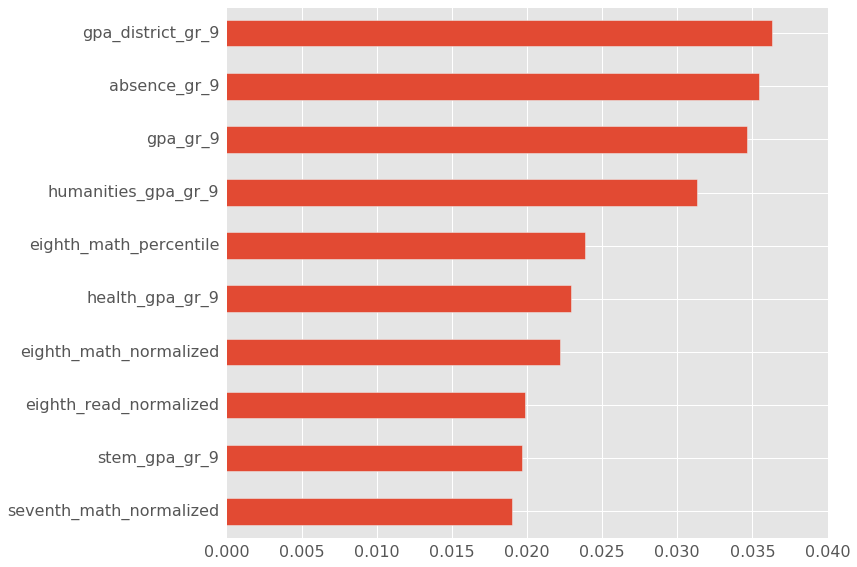

time: 11.8 s


In [155]:
#plot_feature_importance(tab, save=True)
for tab in tables:
    barplot_feature_importance(tab, save=True, savedir='./figs/')

In [147]:
tables = ['08_09_2016_grade_6_param_set_0_RF_ht_8585',
'08_09_2016_grade_7_param_set_7_RF_ht_10497',
'08_09_2016_grade_8_param_set_13_RF_ht_13254',
'08_09_2016_grade_9_param_set_0_RF_ht_8645',
'08_09_2016_grade_10_param_set_0_RF_ht_8680']
top10_feautres = {}
topN = 10
with postgres_pgconnection_generator() as conn:
    for table in tables:
        df = read_table_to_df(conn, table, schema='feature_scores', nrows=-1)
        #df = df.sort_values(by=['importance'], ascending=False)
        #top10_feautres[table] = list(df.feature[:topN])

time: 72.8 ms


In [148]:
df

,index,feature,importance
0,0,gpa_district_gr_9,3.628950e-02
1,1,absence_gr_9,3.540471e-02
2,2,gpa_gr_9,3.465108e-02
3,3,humanities_gpa_gr_9,3.130257e-02
4,4,eighth_math_percentile,2.384897e-02
5,5,health_gpa_gr_9,2.292399e-02
6,6,eighth_math_normalized,2.220914e-02
7,7,eighth_read_normalized,1.984469e-02
8,8,stem_gpa_gr_9,1.966379e-02
9,9,seventh_math_normalized,1.897150e-02


time: 25.1 ms


In [145]:
top10_feautres

{'08_09_2016_grade_10_param_set_0_RF_ht_8680': ['gpa_district_gr_9',
  'absence_gr_9',
  'gpa_gr_9',
  'humanities_gpa_gr_9',
  'eighth_math_percentile',
  'health_gpa_gr_9',
  'eighth_math_normalized',
  'eighth_read_normalized',
  'stem_gpa_gr_9',
  'seventh_math_normalized'],
 '08_09_2016_grade_6_param_set_0_RF_ht_8585': ['sixth_math_percentile',
  'eighth_math_normalized',
  'sixth_math_normalized',
  'eighth_math_percentile',
  'fifth_socstudies_normalized',
  'eighth_science_normalized',
  'eighth_science_percentile',
  'absence_gr_5',
  'sixth_read_normalized',
  'seventh_read_percentile'],
 '08_09_2016_grade_7_param_set_7_RF_ht_10497': ['eighth_math_percentile',
  'eighth_math_normalized',
  'sixth_math_percentile',
  'sixth_math_normalized',
  'eighth_read_normalized',
  'gpa_district_gr_6',
  'absence_gr_6',
  'fifth_socstudies_normalized',
  'eighth_science_normalized',
  'seventh_read_normalized'],
 '08_09_2016_grade_8_param_set_13_RF_ht_13254': ['gpa_gr_7',
  'gpa_district

time: 4.78 ms
